In [73]:
%load_ext autoreload
%autoreload 2 
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import toblerone as tob 
import regtricks as rt
import pyvista as pv 
import trimesh
from svb.main import run

try:
    import tensorflow.compat.v1 as tf
    tf.disable_v2_behavior()
except ImportError:
    import tensorflow as tf

# To make tests repeatable
tf.set_random_seed(1)
np.random.seed(1)

pv.set_plot_theme('document')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Set the properties of the simulated data
num_times = 200
sq_len = 5
vox_size = 2 
name = "example_data"
true_params = {
"amp1" : 10.0, # the true amplitude of the model
"amp2" : 10.0,
"r1" : 1.0,    # the true decay rate
"r2" : 10.0,
"noise_sd" : 1.0,
}
true_var = true_params["noise_sd"]**2

# For time being, make sure we have a good range of samples based on the choice of R1
dt = 5.0/(true_params["r1"] * num_times)

In [34]:
# Generate test data and write to filenames
shape = (sq_len, sq_len, sq_len, num_times)
data = np.zeros(shape)
for t_idx in range(num_times):
    t = t_idx*dt
    data[..., t_idx] = true_params["amp1"]*math.exp(-true_params["r1"]*t) + \
                       true_params["amp2"]*math.exp(-true_params["r2"]*t)
data_noisy = data + np.random.normal(0, true_params["noise_sd"], size=shape)
data_noisy.shape

(5, 5, 5, 200)

In [38]:
# Create a reference voxel grid for the data 
ref_spc = rt.ImageSpace.create_axis_aligned(np.zeros(3), 3 * [sq_len], 3 * [vox_size])

# Generate the point cloud of voxel centres
vox_cents = ref_spc.voxel_centres().reshape(-1,3)
voxel_poly = pv.PolyData(vox_cents)
ref_spc

ImageSpace with properties:
size:          [   5.000    5.000    5.000], 
voxel size:    [   2.000    2.000    2.000], 
field of view: [  10.000   10.000   10.000],
vox2world:     [   2.000    0.000    0.000    1.000]
               [   0.000    2.000    0.000    1.000]
               [   0.000    0.000    2.000    1.000]
               [   0.000    0.000    0.000    1.000]
loaded from: (no direct file counterpart)

In [39]:
# Generate a spherical surface
sph_mesh = trimesh.creation.icosphere(2, ((sq_len * vox_size)/2.2))
surf = tob.Surface.manual(sph_mesh.vertices + (sq_len * vox_size)/2,    
                                sph_mesh.faces)
surf

Surface with 162 points and 320 triangles. 
min (X,Y,Z):  [0.45454547 0.45454547 0.45454547]
mean (X,Y,Z): [5.000001 5.       4.999999]
max (X,Y,Z):  [9.545455 9.545455 9.545455]

In [40]:
# Plot the voxels and surface together (note the sphere seems to spill out of the voxel grid, this is because voxel centres are plotted, not the full bounding box)
plot = pv.BackgroundPlotter(notebook=True)
plot.add_mesh(surf.to_polydata(), 
    scalars=np.ones(surf.points.shape[0]), opacity=0.3, 
    show_edges=True, show_scalar_bar=True)
plot.add_mesh(voxel_poly)
plot.show()

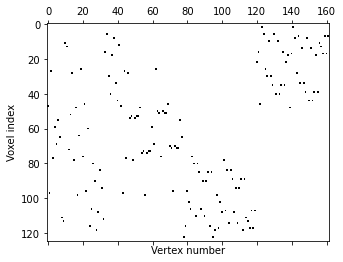

In [70]:
# Form the weighting matrix for surface -> voxels
# We will use weighted averaging (no PV weighting etc)
surf2vol_weights = np.zeros((ref_spc.size.prod(), surf.points.shape[0]))
vertices_ijk = rt.aff_trans(ref_spc.world2vox, surf.points).round(0)
vertices_inds = np.ravel_multi_index(vertices_ijk.T.astype('i4'), ref_spc.size)
for vtx_number, vtx_ind in enumerate(vertices_inds):
    surf2vol_weights[vtx_ind, vtx_number] = 1 

assert (surf2vol_weights.sum(0) == 1).all()
divisor = surf2vol_weights.sum(1)
surf2vol_weights[surf2vol_weights == 0] = -1
surf2vol_weights /= divisor[:,None]
surf2vol_weights[surf2vol_weights < 0] = 0
mask = (surf2vol_weights.sum(1) > 0)
assert (surf2vol_weights[mask,:].sum(1) == 1).all()
plt.spy(surf2vol_weights)
plt.xlabel('Vertex number')
plt.ylabel('Voxel index')
plt.show()

In [79]:
# Train model without covariance
options = {
    "learning_rate" : 0.005,
    "batch_size" : 10,
    "sample_size" : 10,
    "epochs" : 250,
    "log_stream" : sys.stdout,
    "save_mean" : True,
    "save_var" : True,
    "save_param_history" : True,
    "save_cost" : True,
    "save_cost_history" : True,
    "save_model_fit" : True,
    "save_log" : True,
    "n2v" : surf2vol_weights
}

In [89]:
runtime, svb, training_history = run(data_noisy, "biexp", "example_out_cov", surfaces={'LMS': surf}, infer_covar=True, **options)
mean_cost_history_cov = training_history["mean_cost"]
cost_history_v_cov = training_history["voxel_cost"]
param_history_v_cov = training_history["voxel_params"]
modelfit_cov = svb.evaluate(svb.modelfit)
means_cov = svb.evaluate(svb.model_means)
variances_cov = svb.evaluate(svb.model_vars)


INFO : SVB 0.0.2.post126
Data voxels: 125
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 1.]]
INFO : Model: Bi-Exponential model: 0.0.2.post126
INFO :  - Time separation between volumes: 1.0
INFO :  - Time offset for first volume: 0.0


ValueError: Dimensions 162 and 2 are not compatible